In [2]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [6]:
# Importing dependencies
import yfinance as yf
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

### Data Preprocessing

In [36]:
# Loading the dataset
df = pd.DataFrame(data=yf.download('LINK-USD', '2010-01-01', '2024-03-13'))
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.216713,0.248233,0.195411,0.223969,0.223969,3347920
2017-11-10,0.224700,0.231280,0.180161,0.187602,0.187602,2125460
2017-11-11,0.186398,0.197687,0.166026,0.179770,0.179770,2238980
2017-11-12,0.179667,0.198376,0.145948,0.170898,0.170898,5455200
2017-11-13,0.169117,0.205014,0.168743,0.183071,0.183071,2992650
...,...,...,...,...,...,...
2024-03-08,20.126860,20.390388,19.321224,19.741352,19.741352,590191572
2024-03-09,19.741385,20.343550,19.719904,20.028526,20.028526,414335240
2024-03-10,20.028534,21.943203,19.520350,21.754612,21.754612,696612444


In [37]:
# Correlation matrix
df.corr()['Close']

Open         0.995411
High         0.997831
Low          0.997796
Close        1.000000
Adj Close    1.000000
Volume       0.205734
Name: Close, dtype: float64

In [38]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    2.316000e+03
mean     6.723051e+08
std      3.624850e+09
min      3.987730e+05
25%      4.805269e+07
50%      3.162488e+08
75%      8.007572e+08
max      1.705493e+11
Name: Volume, dtype: float64


In [39]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [52]:
#Build and train the model
def fit_model(train,val,timesteps,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=32))
    model.add(Dense(units=1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    #print(model.summary())

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [41]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)

    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat


In [42]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [43]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Model Building

In [44]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2316, 3)
                Close       High      Volume
Date                                        
2024-03-08  19.741352  20.390388   590191572
2024-03-09  20.028526  20.343550   414335240
2024-03-10  21.754612  21.943203   696612444
2024-03-11  21.289614  22.825249  1265727284
2024-03-12  20.666775  21.323486   824857503


In [46]:
# Train Val Test Split
train_start = dt.date(2010,1,1)
train_end = dt.date(2020,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2021,1,1)
val_end = dt.date(2022,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2023,1,1)
test_end = dt.date(2024,3,13)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(1149, 3) (730, 3) (437, 3)


In [47]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1149, 3) (730, 3) (437, 3)


In [53]:
timesteps = 50
batch_size = 64
num_epochs = 250

Epoch 1/250
18/18 [==============================] - 12s 295ms/step - loss: 0.0331 - val_loss: 0.3594
Epoch 2/250
18/18 [==============================] - 5s 272ms/step - loss: 0.0689 - val_loss: 0.6819
Epoch 3/250
18/18 [==============================] - 4s 212ms/step - loss: 0.0100 - val_loss: 0.2723
Epoch 4/250
18/18 [==============================] - 4s 208ms/step - loss: 0.0091 - val_loss: 0.2917
Epoch 5/250
18/18 [==============================] - 5s 260ms/step - loss: 0.0093 - val_loss: 0.2831
Epoch 6/250
18/18 [==============================] - 4s 221ms/step - loss: 0.0266 - val_loss: 0.3499
Epoch 7/250
18/18 [==============================] - 4s 216ms/step - loss: 0.0391 - val_loss: 0.7913
Epoch 8/250
18/18 [==============================] - 4s 253ms/step - loss: 0.0241 - val_loss: 0.5089
Epoch 9/250
18/18 [==============================] - 4s 223ms/step - loss: 0.0175 - val_loss: 0.3083
Epoch 10/250
18/18 [==============================] - 5s 279ms/step - loss: 0.0126 - val_l

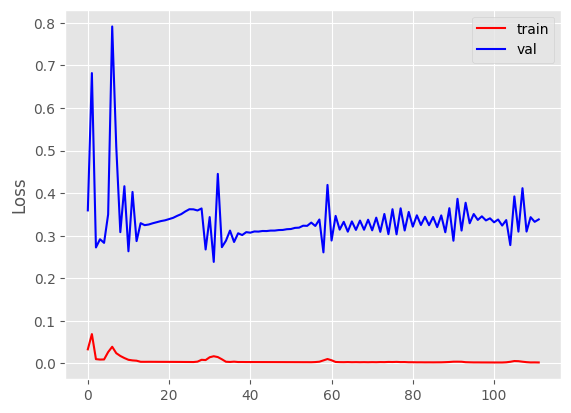

In [54]:
model,train_error,val_error = fit_model(train,val,timesteps,batch_size,num_epochs)
plot_error(train_error,val_error)

13/13 [==============================] - 3s 46ms/step
MSE = 0.03630395139492599
RMSE = 0.1905359582727785
R-Squared Score = 0.3964036612553302


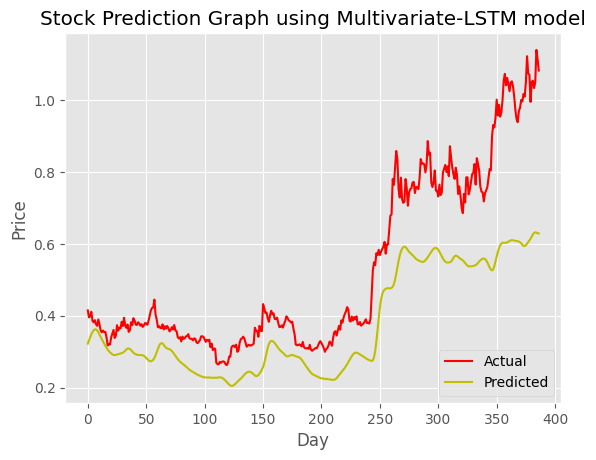

In [55]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [57]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
#del model # Deletes the model
# Load a model
model = load_model('MV3-LSTM_50_[40,35]_1e-3_64.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Cross-Validation

In [58]:
# Hyperparameters
timesteps = 50
batch_size = 64
num_epochs = 50

In [59]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the multivariate series
print(series.shape)
print(series.tail())

(2316, 3)
                Close       High      Volume
Date                                        
2024-03-08  19.741352  20.390388   590191572
2024-03-09  20.028526  20.343550   414335240
2024-03-10  21.754612  21.943203   696612444
2024-03-11  21.289614  22.825249  1265727284
2024-03-12  20.666775  21.323486   824857503


In [60]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[1.51217665e-03, 1.55473939e-03, 1.72920879e-05],
       [8.13529291e-04, 1.23311030e-03, 1.01242913e-05],
       [6.63068429e-04, 5.95790555e-04, 1.07899068e-05],
       ...,
       [4.15137914e-01, 4.13147427e-01, 4.08219325e-03],
       [4.06204821e-01, 4.29881425e-01, 7.41915266e-03],
       [3.94239445e-01, 4.01390285e-01, 4.83414791e-03]])

### Split I

In [61]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

In [62]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,timesteps,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("MV3-LSTM-Split1.h5")

TypeError: fit_model() missing 1 required positional argument: 'epochs'

### Split II

In [63]:

train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split2.h5")

ValueError: Expected input data to be non-empty.

### Split III

Split 3
MSE = 5.750010686281572e-05
RMSE = 0.007582882490373678
R-Squared Score = 0.9623244628902942


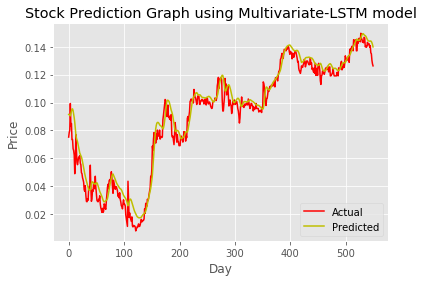

In [ ]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split3.h5")

### Split IV

Split 4
MSE = 0.0003351343181146015
RMSE = 0.01830667414126885
R-Squared Score = 0.983354736836396


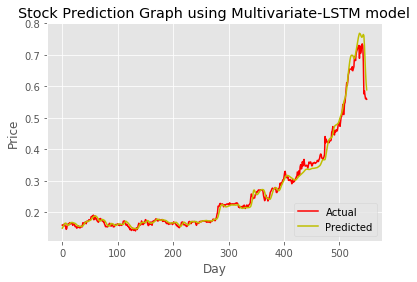

In [ ]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split4.h5")

### Split V

Split 5
MSE = 0.0017749325670554344
RMSE = 0.04212994857646321
R-Squared Score = 0.7975629191961274


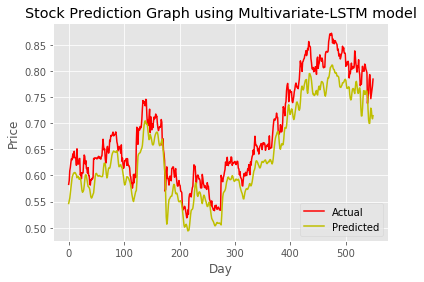

In [ ]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split5.h5")

In [ ]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.0004895794
Avg. RMSE = 0.0179982514
Avg. R2-score = 0.9214646906


In [ ]:
CV_results.to_csv('MV3-LSTM_CrossValidation.csv')
train_loss.to_csv('MV3-LSTM_CrossValidation_TrainLoss.csv')
val_loss.to_csv('MV3-LSTM_CrossValidation_ValLoss.csv')